In [0]:
!pip install tensorflow==2.0.0-alpha0 --upgrade
!pip install tensorflow-gpu==2.0.0-alpha0 --upgrade

In [0]:
from __future__ import absolute_import, division, print_function

from datetime import datetime
import os
from shutil import copyfile

import tensorflow as tf
print('Tensorflow Version: ', tf.__version__)
print('GPU: ', tf.test.gpu_device_name())
from tensorflow.compat.v1.keras import Sequential, layers, models
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')
drive_dest_folder = '/content/gdrive/My Drive/Colab Notebooks/data'

# MNIST Dataset parameters.
pixel_res = 28
num_features = pixel_res * pixel_res # data features (img shape: 28*28).

# Network parameters.
noise_dim = 100 # Noise data points.

Tensorflow Version:  2.0.0-alpha0
GPU:  /device:GPU:0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def generator_model():
    model = Sequential()
    model.add(layers.Dense(1024, input_shape=(noise_dim,)))
    model.add(layers.Activation('tanh'))
    model.add(layers.Dense(128*7*7))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(64, (5, 5), padding='same'))
    model.add(layers.Activation('tanh'))
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(1, (5, 5), padding='same'))
    model.add(layers.Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(layers.Reshape(
      target_shape=(pixel_res, pixel_res, 1),
      input_shape=(pixel_res, pixel_res, 1)))
    model.add(
      layers.Conv2D(64, (5, 5), padding='same')
    )
    model.add(layers.Activation('tanh'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (5, 5)))
    model.add(layers.Activation('tanh'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.Activation('tanh'))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    return model


def create_combination(gen, dis):
  new_model = tf.keras.Sequential()
  new_model.add(gen)
  dis.trainable = False
  new_model.add(dis)
  return new_model

In [0]:
def dated_filename():
  return str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))


def save_checkpoint(model, name):
  checkpoint_name = '{0}_{1}.ckpt'.format(name, dated_filename())
  print('Saving -> {}'.format(checkpoint_name))
  model.save_weights(
      filepath=os.path.join(drive_dest_folder, checkpoint_name))


def load_latest_checkpoint(model, name):
  model_files = [
      f
      for f in os.listdir(drive_dest_folder)
      if name in f and 'ckpt' in f
  ]
  model_files.sort()
  latest_file_name = '{}.ckpt'.format(model_files[-1].split('.')[0])
  latest_filepath = os.path.join(drive_dest_folder, latest_file_name)
  print('Loading -> {}'.format(latest_filepath))
  model.load_weights(filepath=latest_filepath)
  return model


def save_model(model, name):
  blob_name = '{0}_{1}.h5'.format(name, dated_filename())
  print('Saving -> {}'.format(blob_name))
  model.save(os.path.join(drive_dest_folder, blob_name))


def load_latest_model(name):
  model_files = [
      f
      for f in os.listdir(drive_dest_folder)
      if name in f and 'h5' in f
  ]
  model_files.sort()
  latest_file_name = model_files[-1]
  latest_filepath = os.path.join(drive_dest_folder, latest_file_name)
  print('Loading -> {}'.format(latest_filepath))
  model = tf.keras.models.load_model(latest_filepath)
  return model

In [0]:
loading = False
if loading:
  generator = load_latest_model('generator')
  discriminator = load_latest_model('discriminator')
else:
  generator = generator_model()
  discriminator = discriminator_model()
combined = create_combination(generator, discriminator)

(36, 28, 28, 1)


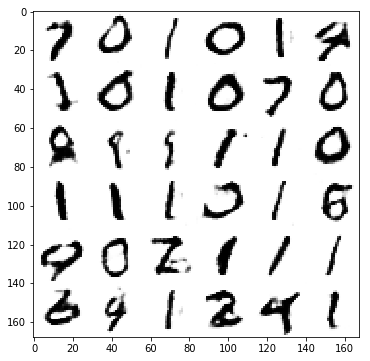

In [0]:
# Visualize predictions.
import matplotlib.pyplot as plt


def generate_sliding_noise(indexes_to_slide=[0]):
  noise_line = np.random.normal(-1., 1., size=noise_dim).astype(np.float32)
  noise = np.zeros([36, 100]).astype(np.float32)
  for i in range(noise.shape[0]):
    noise[i] = noise_line
    for n in indexes_to_slide:
      noise[i][n] = ((i / (noise.shape[0] - 1)) * 2) - 1
  return noise


def draw_noise(z):
  # Generate image from noise.
  g = generator.predict(z)
  print(g.shape)
  # Rescale to original [0, 1]
  g = (g + 1.) / 2
  # Reverse colours for better display
  g = -1 * (g - 1)
  canvas = np.empty((28 * n, 28 * n))
  for i in range(n):
      for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[(i * n) + j].reshape([28, 28])
  plt.figure(figsize=(n, n))
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()


# Generate images from noise, using the generator network.
n = 6
# Noise input.
z = np.random.normal(-1., 1., size=[n * n, noise_dim]).astype(np.float32)
# draw_noise(generate_sliding_noise([10,20,30,40,50,60, 70, 80,90]))
draw_noise(z)

In [0]:
# Training parameters.
learning_rate = 0.0002
training_steps = 20000
batch_size = 128
display_step = 500

In [0]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.
# reshape for the disciminator
x_train = np.reshape(x_train, (-1, pixel_res, pixel_res, 1))
x_test = np.reshape(x_test, (-1, pixel_res, pixel_res, 1))
# Rescale to [-1, 1], the input range of the discriminator
x_train = (x_train * 2) - 1
x_test = (x_test * 2) - 1

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [0]:
generator.compile(
    loss='binary_crossentropy', optimizer="SGD")

discriminator.trainable = False
combined.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(
        lr=learning_rate, momentum=0.9, nesterov=True
    )
)

discriminator.trainable = True
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(
        lr=learning_rate, momentum=0.9, nesterov=True
    )
)

true_labels = tf.ones([batch_size], dtype=tf.float32)
false_labels = tf.zeros([batch_size], dtype=tf.float32)

In [0]:
# Run training for the given number of steps.
for i, (batch_x, _) in enumerate(train_data.take(training_steps)):
    
    if i % display_step == 0:
      print('On Batch ', i, '/', training_steps)
    
    # Generate noise.
    noise_input = np.random.normal(
        -1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    # use noise to create fake images
    fake_images = generator.predict(noise_input)
    # train the discriminator, using both fake and real images
    discriminator.trainable = True
    discriminator.train_on_batch(fake_images, false_labels)
    discriminator.train_on_batch(batch_x, true_labels)
    
    # Generate noise.
    noise_input = np.random.normal(
        -1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    discriminator.trainable = False
    combined.train_on_batch(noise_input, true_labels)


print('done')

On Batch  0 / 20000
On Batch  500 / 20000
On Batch  1000 / 20000
On Batch  1500 / 20000
On Batch  2000 / 20000
On Batch  2500 / 20000
On Batch  3000 / 20000
On Batch  3500 / 20000
On Batch  4000 / 20000
On Batch  4500 / 20000
On Batch  5000 / 20000
On Batch  5500 / 20000
On Batch  6000 / 20000
On Batch  6500 / 20000
On Batch  7000 / 20000
On Batch  7500 / 20000
On Batch  8000 / 20000
On Batch  8500 / 20000
On Batch  9000 / 20000
On Batch  9500 / 20000
On Batch  10000 / 20000
On Batch  10500 / 20000
On Batch  11000 / 20000
On Batch  11500 / 20000
On Batch  12000 / 20000
On Batch  12500 / 20000
On Batch  13000 / 20000
On Batch  13500 / 20000
On Batch  14000 / 20000
On Batch  14500 / 20000
On Batch  15000 / 20000
On Batch  15500 / 20000
On Batch  16000 / 20000
On Batch  16500 / 20000
On Batch  17000 / 20000
On Batch  17500 / 20000
On Batch  18000 / 20000
On Batch  18500 / 20000
On Batch  19000 / 20000
On Batch  19500 / 20000
done


In [0]:
save_model(generator, 'generator')
save_model(discriminator, 'discriminator')

Saving -> generator_2019_05_24_00_39_17.h5
Saving -> discriminator_2019_05_24_00_39_17.h5
